In [1]:
import os
import io
import math
import zipfile
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import networkx as nx

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

In [4]:
from textblob import TextBlob
from statsmodels.tsa.arima.model import ARIMA

In [5]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=3c7b364f6699ccc5f156bcaca056c38f0864d5bba9f3945b61a86fc04edf82db
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [7]:
from fpdf import FPDF
from google.colab import files

In [8]:
OUTDIR = "/content/advanced_netflix_outputs"
os.makedirs(OUTDIR, exist_ok=True)

In [10]:
print("Please upload your Netflix dataset CSV (e.g., netflix.csv). If you have user_ratings.csv (optional), upload it next.")
uploaded = files.upload()  # user uploads files via Colab UI

Please upload your Netflix dataset CSV (e.g., netflix.csv). If you have user_ratings.csv (optional), upload it next.


Saving Netflix Dataset.csv to Netflix Dataset.csv


In [11]:
# Determine filenames
if len(uploaded) == 0:
    raise Exception("No files uploaded. Re-run and upload netflix CSV.")
files_list = list(uploaded.keys())
print("Uploaded:", files_list)

Uploaded: ['Netflix Dataset.csv']


In [12]:
# Attempt to find netflix CSV
netflix_fname = None
for f in files_list:
    if "netflix" in f.lower() and f.lower().endswith(('.csv', '.txt')):
        netflix_fname = f
        break
# else take first CSV
if netflix_fname is None:
    for f in files_list:
        if f.lower().endswith('.csv'):
            netflix_fname = f
            break
if netflix_fname is None:
    raise Exception("Couldn't find a CSV among uploaded files. Please upload your netflix dataset CSV.")

print("Using Netflix file:", netflix_fname)

Using Netflix file: Netflix Dataset.csv


In [13]:
# Optional user ratings
user_ratings_fname = None
for f in files_list:
    if "rating" in f.lower() or "user" in f.lower():
        if f != netflix_fname:
            user_ratings_fname = f
            break

if user_ratings_fname:
    print("Found optional user rating file:", user_ratings_fname)
else:
    print("No user ratings file uploaded — collaborative recommender will use simulated implicit interactions.")

No user ratings file uploaded — collaborative recommender will use simulated implicit interactions.


In [14]:
# ---------- Step B: Load Data ----------
df = pd.read_csv(netflix_fname)
print("\nDataset loaded. Shape:", df.shape)
print("Columns:", df.columns.tolist())


Dataset loaded. Shape: (7789, 11)
Columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']


In [15]:
# ---------- Step C: Basic Cleaning & Feature Engineering ----------
# Standardize expected columns if present; provide safety if missing
expected_cols = ['show_id','type','title','director','cast','country','date_added','release_year','rating','duration','listed_in','description']
# Not required to have all; handle flexibly
 # Convert column names to lower-case variants to ease mapping
cols_lower = {c.lower():c for c in df.columns}
def get_col(*names):
  for n in names:
    if n in cols_lower: return cols_lower[n]
  return None

In [16]:
# Map columns
col_title = get_col('title','name')
col_type = get_col('type')
col_date = get_col('date_added','date added','added')
col_country = get_col('country')
col_listed = get_col('listed_in','genres','category')
col_desc = get_col('description','synopsis','summary')
col_director = get_col('director')
col_cast = get_col('cast','actors')
col_rating = get_col('rating')
col_duration = get_col('duration')
col_release = get_col('release_year','release year','year')

In [17]:
# Rename to standard names used below
rename_map = {}
if col_title: rename_map[col_title] = 'title'
if col_type: rename_map[col_type] = 'type'
if col_date: rename_map[col_date] = 'date_added'
if col_country: rename_map[col_country] = 'country'
if col_listed: rename_map[col_listed] = 'listed_in'
if col_desc: rename_map[col_desc] = 'description'
if col_director: rename_map[col_director] = 'director'
if col_cast: rename_map[col_cast] = 'cast'
if col_rating: rename_map[col_rating] = 'rating'
if col_duration: rename_map[col_duration] = 'duration'
if col_release: rename_map[col_release] = 'release_year'
df = df.rename(columns=rename_map)

In [18]:
# Ensure key columns exist
if 'title' not in df.columns:
  raise Exception("Your dataset must include a 'title' column.")

In [19]:
# Clean common columns
df['type'] = df['type'].fillna('Unknown').astype(str)
df['listed_in'] = df['listed_in'].fillna('Unknown').astype(str)
df['country'] = df['country'].fillna('Unknown').astype(str)
df['director'] = df.get('director', pd.Series(['Unknown']*len(df))).fillna('Unknown').astype(str)
df['cast'] = df.get('cast', pd.Series(['Unknown']*len(df))).fillna('Unknown').astype(str)
df['description'] = df.get('description', pd.Series(['']*len(df))).fillna('').astype(str)
df['rating'] = df.get('rating', pd.Series(['Unknown']*len(df))).fillna('Unknown').astype(str)
df['duration'] = df.get('duration', pd.Series(['Unknown']*len(df))).fillna('Unknown').astype(str)

In [20]:
# Date processing
try:
  df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
  df['year_added'] = df['date_added'].dt.year
except Exception:
  df['year_added'] = pd.to_numeric(df.get('release_year',
pd.Series([np.nan]*len(df))), errors='coerce')

In [21]:
# Create a short id column
df['nid'] = range(1, len(df)+1)
# Save cleaned copy
df.to_csv(os.path.join(OUTDIR, "netflix_cleaned.csv"), index=False)
print("Cleaned dataset saved to:", os.path.join(OUTDIR, "netflix_cleaned.csv"))

Cleaned dataset saved to: /content/advanced_netflix_outputs/netflix_cleaned.csv


In [22]:
# ---------- Section 1: EDA & Graphs ----------
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

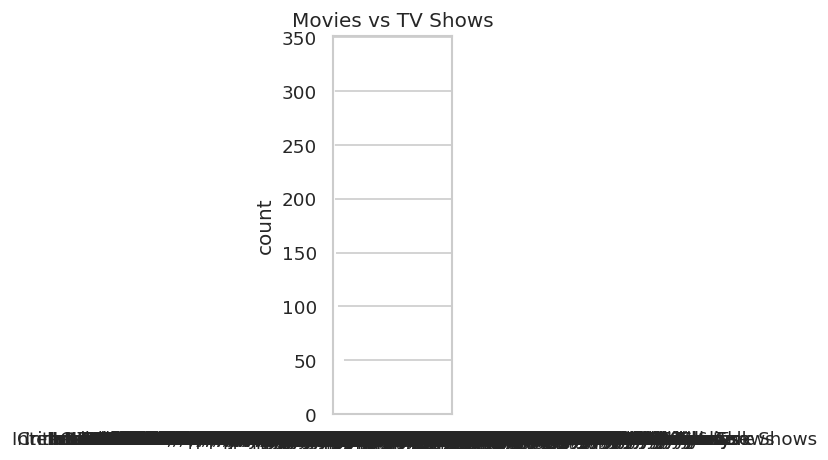

In [25]:
# 1. Movies vs TV Shows (Matplotlib)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index, palette='Set2')
plt.title('Movies vs TV Shows')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'movies_vs_tvshows.png'))
plt.show()

In [26]:
# 2. Interactive Plotly histogram
fig = px.histogram(df, x='type', color='type', title='Movies vs TV Shows', text_auto=True)
fig.write_html(os.path.join(OUTDIR, 'movies_vs_tvshows_plotly.html'))
fig.show()

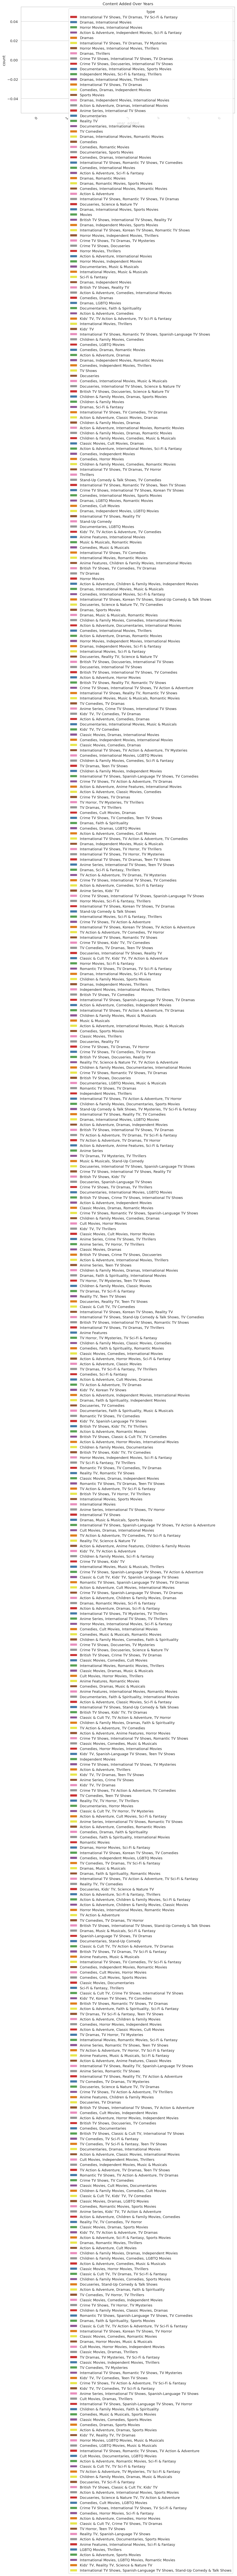

In [27]:
# 3. Content added over years
plt.figure(figsize=(12,6))
order = sorted(df['year_added'].dropna().unique())
sns.countplot(data=df, x='year_added', hue='type', palette='Set1', order=order)
plt.title('Content Added Over Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'content_over_years.png'))
plt.show()

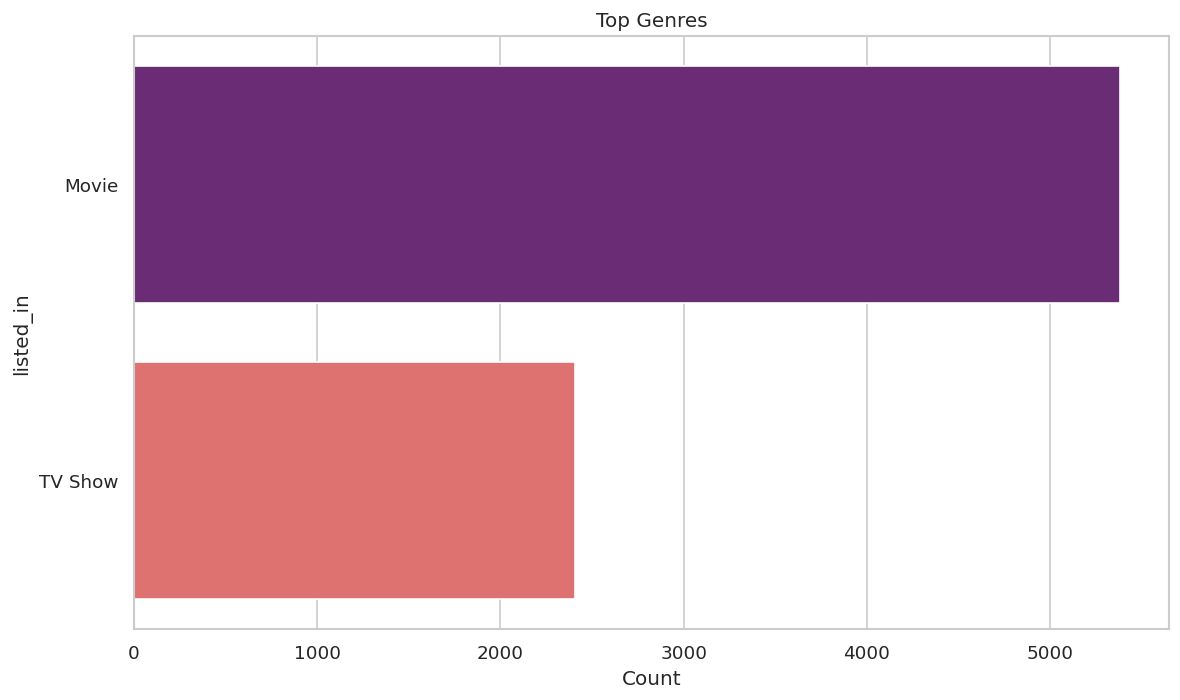

In [28]:
# 4. Top Genres (explode)
genres_series = df['listed_in'].str.split(',').explode().str.strip()
top_genres = genres_series.value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='magma')
plt.title('Top Genres')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'top_genres.png'))
plt.show()

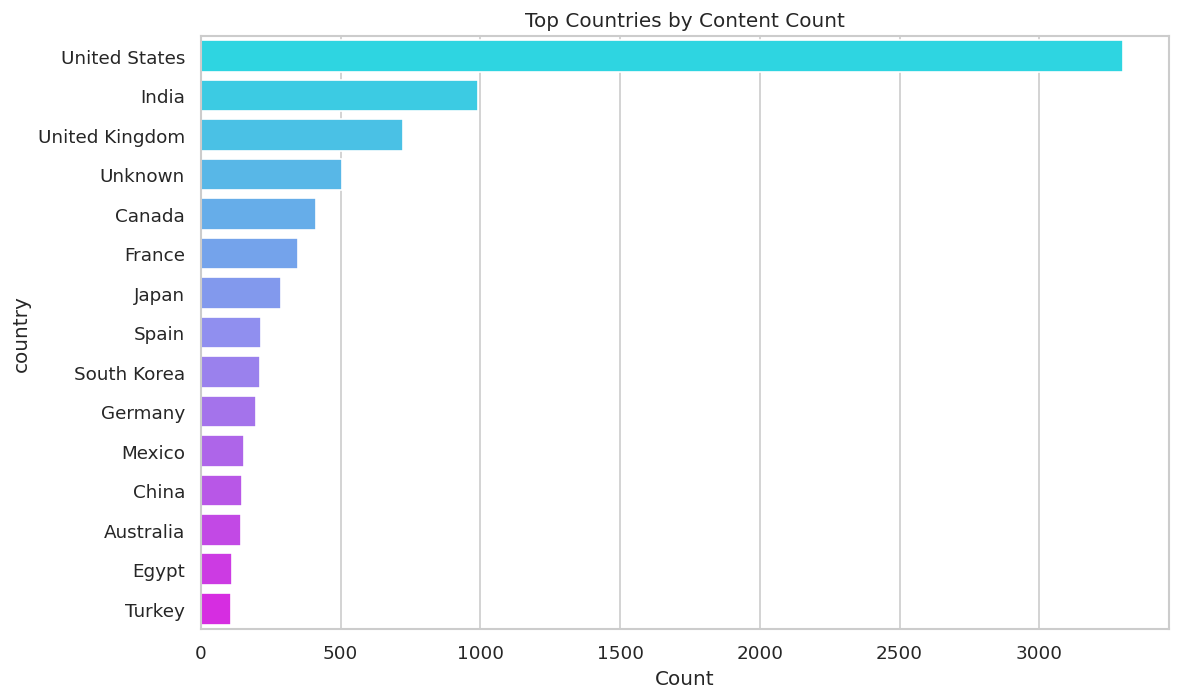

In [29]:
# 5. Country contributions (top 15)
country_counts = df['country'].str.split(',').explode().str.strip().value_counts()
top_countries = country_counts.head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='cool')
plt.title('Top Countries by Content Count')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'top_countries.png'))
plt.show()

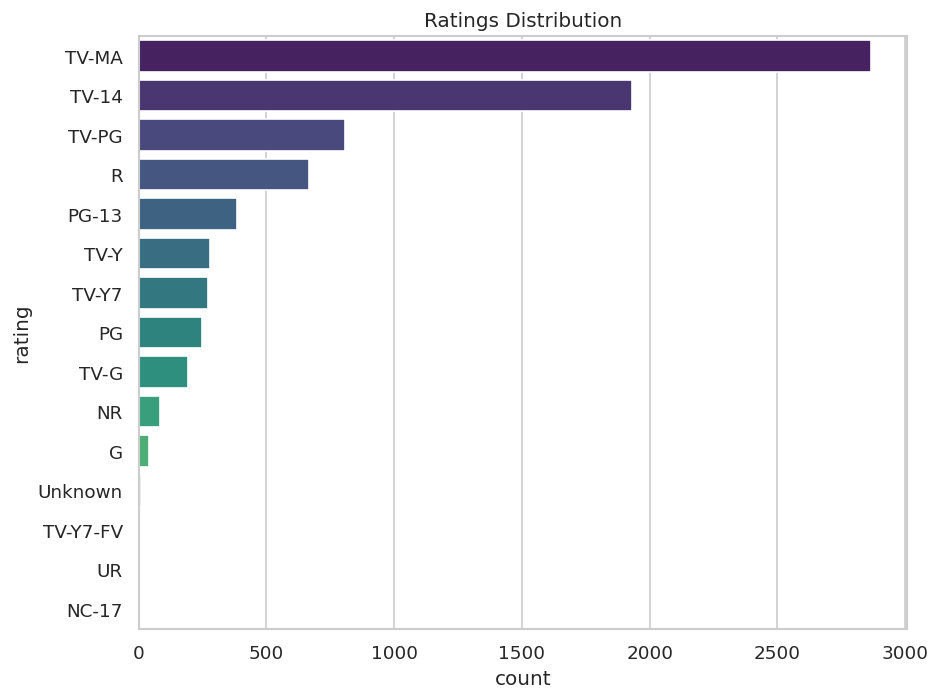

In [30]:
# 6. Ratings distribution
plt.figure(figsize=(8,6))
sns.countplot(y=df['rating'], order=df['rating'].value_counts().index, palette='viridis')
plt.title('Ratings Distribution')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'ratings_distribution.png'))
plt.show()

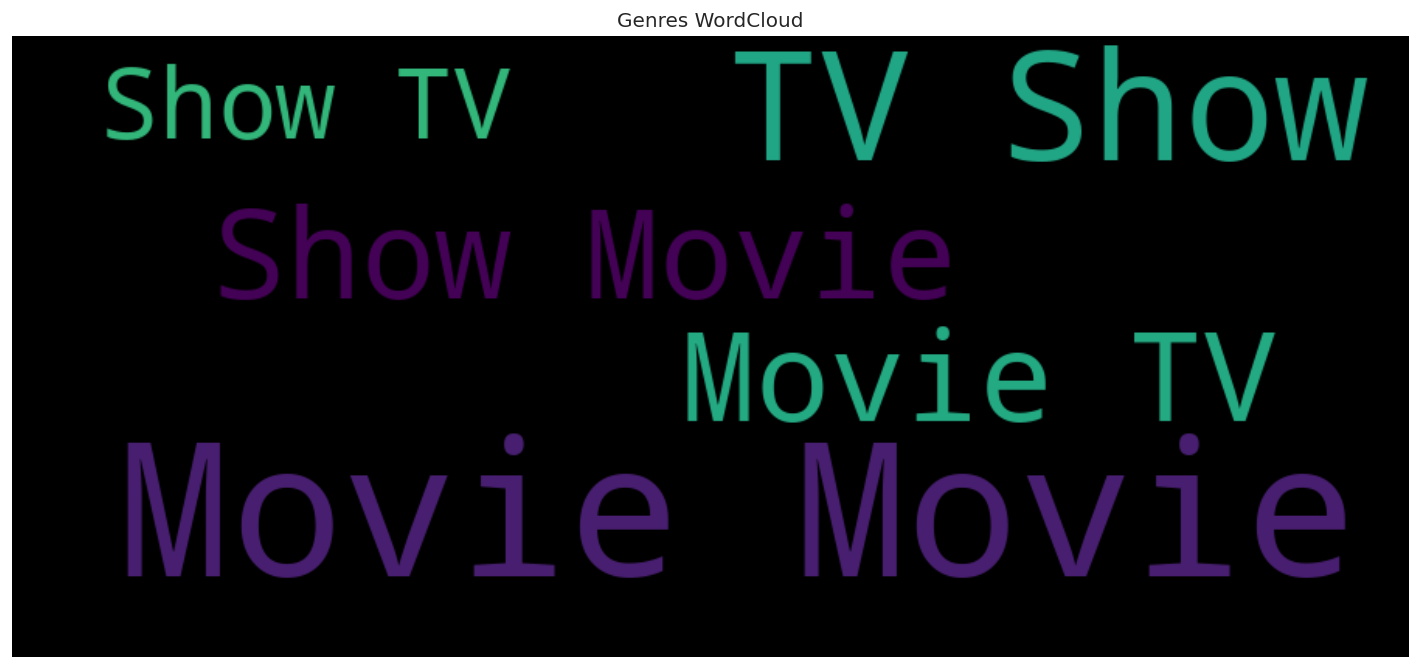

In [31]:
# 7. WordCloud for genres
wc_text = " ".join(df['listed_in'].dropna().values)
wc = WordCloud(width=900, height=400, background_color='black').generate(wc_text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Genres WordCloud')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'genres_wordcloud.png'))
plt.show()

In [32]:
# Save small EDA tables
top_genres.to_csv(os.path.join(OUTDIR,'top_genres.csv'))
top_countries.to_csv(os.path.join(OUTDIR,'top_countries.csv'))

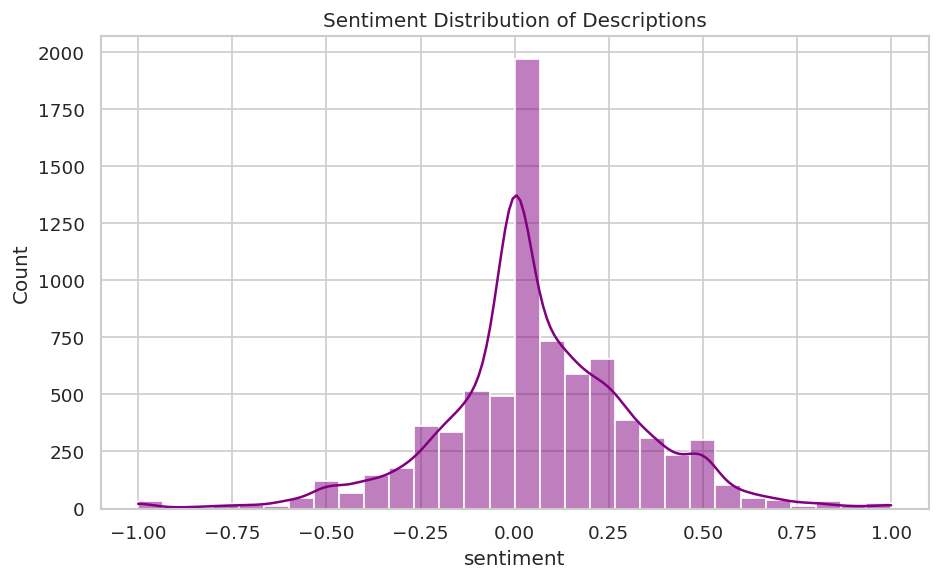

In [33]:
# ---------- Section 2: Sentiment Analysis ----------
# Using TextBlob for polarity (-1..1)
df['sentiment'] = df['description'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(8,5))
sns.histplot(df['sentiment'], bins=30, kde=True, color='purple')
plt.title('Sentiment Distribution of Descriptions')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'sentiment_distribution.png'))
plt.show()

In [34]:
# ---------- Section 3: Clustering ----------
# Use type, rating and duration (string) to create text features
clust_features = (df['type'].astype(str) + " " + df['rating'].astype(str) + " " + df['duration'].astype(str))
tv = TfidfVectorizer(max_features=2000, stop_words='english')
X_clust = tv.fit_transform(clust_features)

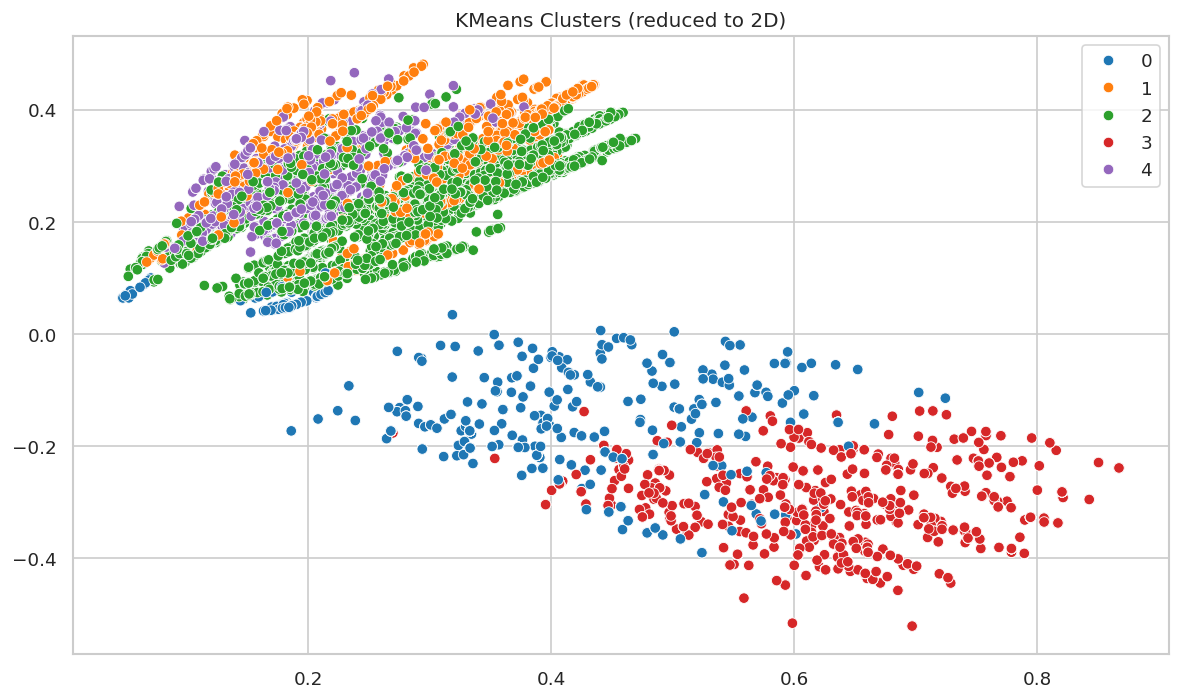

In [35]:
# Reduce dimensionality for KMeans visualization using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_clust)
k = 5
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(X_clust)
df['cluster'] = labels
plt.figure(figsize=(10,6))
palette = sns.color_palette("tab10", k)
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels, palette=palette, legend='full', s=40)
plt.title('KMeans Clusters (reduced to 2D)')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'clusters_2d.png'))
plt.show()

In [36]:
# Save cluster distribution
df['cluster'].value_counts().to_csv(os.path.join(OUTDIR,'cluster_counts.csv'))

In [37]:
# ---------- Section 4: Content-based Recommendation ----------
# Build TF-IDF on 'listed_in' + 'description' (gives more signal)
rec_corpus = (df['listed_in'].fillna('') + " " + df['description'].fillna(''))
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(rec_corpus)

In [38]:
# compute cosine similarities
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [39]:
# Helper function
title_to_index = pd.Series(df.index, index=df['title']).drop_duplicates()
def recommend_content(title, topn=6):
  if title not in title_to_index:
    return f"Title '{title}' not found in dataset."
  idx = title_to_index[title]
  sim_scores = list(enumerate(cos_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topn]
  indices = [i[0] for i in sim_scores]
  return df[['title','type','year_added','listed_in']].iloc[indices]

In [40]:
# Example usage (try with a real title from your data)
example_title = df['title'].iloc[0]
print("\nExample recommendations for:", example_title)
print(recommend_content(example_title, topn=6))


Example recommendations for: 3%
                   title                                               type  \
5822              Stoked                                           Kids' TV   
2733        High Society                       Dramas, International Movies   
4235               Mosul   Action & Adventure, Dramas, International Movies   
7261  Tu Hai Mera Sunday  Comedies, Independent Movies, International Mo...   
6024              Teresa  International TV Shows, Romantic TV Shows, Spa...   

      year_added listed_in  
5822         NaN   TV Show  
2733         NaN     Movie  
4235         NaN     Movie  
7261         NaN     Movie  
6024         NaN   TV Show  


In [41]:
# Save top-k recommendations for first 50 titles (sample)
recs_sample = {}
for t in df['title'].iloc[:50]:
  out = recommend_content(t, topn=6)
  recs_sample[t] = out['title'].tolist()
pd.DataFrame.from_dict(recs_sample, orient='index').to_csv(os.path.join(OUTDIR,'sample_recommendations.csv'))

In [42]:
# ---------- Section 5: Collaborative-style Recommender (implicit simulated if no real ratings) ----------
# If user uploaded a user ratings file, use it; else create simulated implicit interactions by country-title co-occurrence
if user_ratings_fname:
  ratings = pd.read_csv(user_ratings_fname)
  # Expect columns userId,title,rating
  if set(['userId','title','rating']).issubset(set(ratings.columns)):
    print("Using uploaded user ratings for collaborative filtering.")
    # pivot to user-item matrix
    user_item = ratings.pivot_table(index='userId', columns='title', values='rating').fillna(0)
  else:
    print("Uploaded rating file doesn't have expected columns. Falling back to simulated interactions.")
    user_ratings_fname = None
    if not user_ratings_fname:
      print("Creating simulated implicit user interactions by using 'country' as proxy user and counting titles.")
      # country as user, title as item, count occurrence (if multiple countries, pick first)
      user_country = df.assign(country_first=df['country'].apply(lambda x: str(x).split(',')[0].strip()))
      user_item = pd.crosstab(user_country['country_first'], user_country['title'])
      if user_item.shape[0] < 2:
        # If countries too sparse, use clusters as users
        user_item = pd.crosstab(df['cluster'], df['title'])

In [43]:
# Simulate fake user interactions just for demo
# Each "user" gets a random set of titles
titles = df['title'].dropna().unique()[:500]   # limit to 500 titles for speed
users = [f"user_{i}" for i in range(1, 21)]    # 20 fake users

import random
data = []
for user in users:
    watched = random.sample(list(titles), k=30)  # each user "watched" 30 titles
    for t in watched:
        data.append([user, t, 1])  # 1 = watched (implicit rating)

ratings = pd.DataFrame(data, columns=["userId", "title", "rating"])

# Build user-item matrix
user_item = ratings.pivot_table(index="userId", columns="title", values="rating").fillna(0)

# Compute cosine similarity
user_sim = cosine_similarity(user_item)
user_sim_df = pd.DataFrame(user_sim, index=user_item.index, columns=user_item.index)

print(user_sim_df.head())

userId     user_1   user_10   user_11   user_12   user_13   user_14   user_15  \
userId                                                                          
user_1   1.000000  0.033333  0.100000  0.000000  0.066667  0.000000  0.100000   
user_10  0.033333  1.000000  0.033333  0.200000  0.066667  0.066667  0.033333   
user_11  0.100000  0.033333  1.000000  0.133333  0.033333  0.033333  0.100000   
user_12  0.000000  0.200000  0.133333  1.000000  0.033333  0.066667  0.100000   
user_13  0.066667  0.066667  0.033333  0.033333  1.000000  0.166667  0.066667   

userId    user_16   user_17   user_18   user_19    user_2   user_20    user_3  \
userId                                                                          
user_1   0.066667  0.100000  0.033333  0.066667  0.066667  0.033333  0.033333   
user_10  0.033333  0.100000  0.133333  0.000000  0.066667  0.033333  0.066667   
user_11  0.033333  0.066667  0.033333  0.100000  0.100000  0.066667  0.033333   
user_12  0.066667  0.066667

In [44]:
# Compute cosine similarity between users
user_sim = cosine_similarity(user_item)
user_sim_df = pd.DataFrame(user_sim, index=user_item.index, columns=user_item.index)

In [45]:
# Function to recommend titles for a 'user' (index in user_item)
def recommend_for_user(user_key, topn=10):
  if user_key not in user_item.index:
    return f"User '{user_key}' not found."
  sim_scores = user_sim_df[user_key].sort_values(ascending=False)[1:6]
  similar_users = sim_scores.index.tolist()
  # aggregate items from similar users
  recs = user_item.loc[similar_users].sum().sort_values(ascending=False)
  # remove items the user already has
  recs = recs[~(user_item.loc[user_key] > 0)]
  return recs.head(topn)

In [46]:
# Example user recommendation
sample_user = user_item.index[0]
print("\nCollaborative-style recommendations for user proxy:", sample_user)
print(recommend_for_user(sample_user, topn=10).head(10))


Collaborative-style recommendations for user proxy: user_1
title
Always Be My Maybe     2.0
American Beauty        2.0
1983                   2.0
​Maj Rati ​​Keteki     2.0
A Silent Voice         2.0
An American Tail       2.0
10 Days in Sun City    2.0
Alone in Berlin        2.0
Ajaibnya Cinta         2.0
Alien Warfare          2.0
dtype: float64


In [47]:
# Save user-item matrix (small sample)
user_item.iloc[:50,:50].to_csv(os.path.join(OUTDIR,'user_item_sample.csv'))

In [48]:
# Section 6: Time-Series Forecast for Yearly Content Growth
yearly = df.dropna(subset=['year_added']).groupby('year_added').size().sort_index()
yearly.index = pd.to_datetime(yearly.index.astype(int).astype(str), format='%Y')
yearly_ts = yearly.asfreq('Y').fillna(0)

# Fit ARIMA if sufficient data
if len(yearly_ts) >= 6:
    try:
        from statsmodels.tsa.arima.model import ARIMA

        m = ARIMA(yearly_ts, order=(1,1,1))
        res = m.fit()
        steps = 5
        forecast = res.forecast(steps=steps)

        # Plot
        plt.figure(figsize=(10,5))
        plt.plot(yearly_ts.index.year, yearly_ts.values, label='Historical')
        future_years = [yearly_ts.index.year.max() + i for i in range(1, steps+1)]
        plt.plot(future_years, forecast.values, color='red', marker='o', label='Forecast')
        plt.title('Forecast of Titles Added by Year (ARIMA)')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR,'yearly_forecast.png'))
        plt.show()

        # Save forecast to CSV
        forecast_df = pd.DataFrame({'year': future_years, 'forecast_count': forecast.values})
        forecast_df.to_csv(os.path.join(OUTDIR,'yearly_forecast.csv'), index=False)

    except Exception as e:
        print("ARIMA failed:", e)
else:
    print("Not enough yearly data for ARIMA forecasting.")

Not enough yearly data for ARIMA forecasting.


In [51]:
# Section 7: Choropleth Map of Content by Country
# Prepare country counts and attempt mapping by country names
country_counts_map = df['country'].str.split(',').explode().str.strip().value_counts().reset_index()
country_counts_map.columns = ['country','count']

# Remove unknown / empty
country_counts_map = country_counts_map[~country_counts_map['country'].isin(['Unknown',''])]

if not country_counts_map.empty:
    fig = px.choropleth(
        country_counts_map,
        locations='country',
        locationmode='country names',
        color='count',
        title='World Map: Netflix Content by Country',
        color_continuous_scale='OrRd'
    )
    fig.write_html(os.path.join(OUTDIR,'country_choropleth.html'))
    fig.show()
else:
    print("No valid country data for choropleth map.")

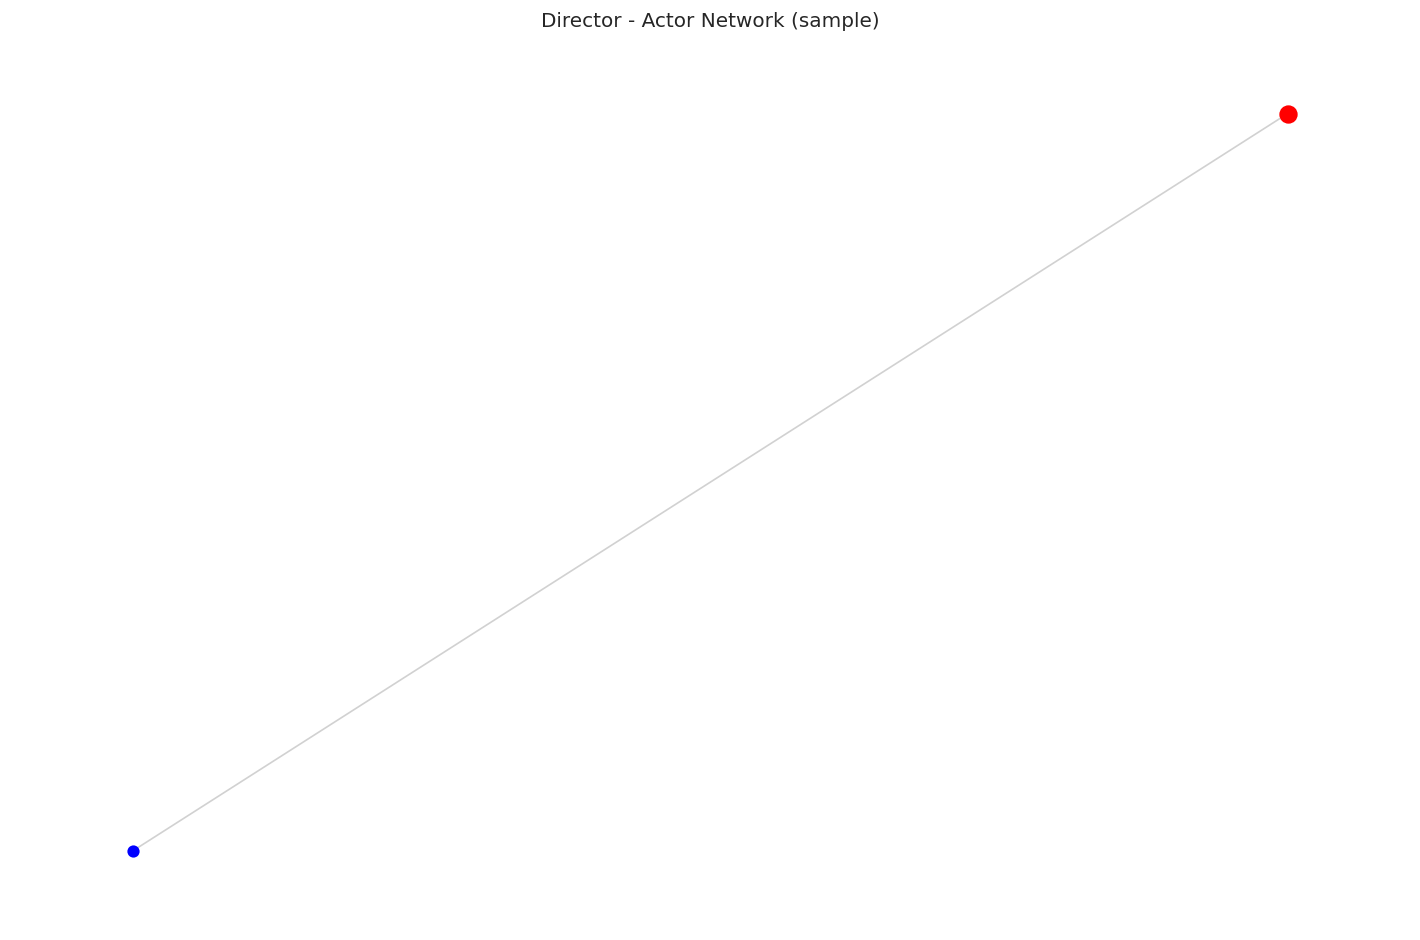

In [52]:
# ---------- Section 8: Cast-Director Network ----------
# Build edges director <-> actor for top N titles to avoid huge graph
N = min(800, len(df))
G = nx.Graph()
for idx, row in df.head(N).iterrows():
  director = row['director']
  actors = [a.strip() for a in str(row['cast']).split(',') if a.strip()]
for a in actors:
  if director and a:
    G.add_node(director, type='director')
    G.add_node(a, type='actor')
    G.add_edge(director, a)
# Plot small network (matplotlib)
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.15, iterations=20)
# draw small degree nodes only to keep readability
degrees = dict(G.degree())
nodes_to_draw = [n for n,d in degrees.items() if degrees[n] >= 1]
# keep all; filter if too big
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if G.nodes[n].get('type')=='director'], node_size=100, node_color='red', label='directors')
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if G.nodes[n].get('type')=='actor'], node_size=40, node_color='blue', label='actors')
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title('Director - Actor Network (sample)')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'director_actor_network.png'))
plt.show()

In [53]:
# ---------- Section 9: Simple Genre Prediction Model (Movie vs TV Show) ----------
# Build a simple classifier: predict type from country + rating (as example)
# Prepare X,y
df_model = df.copy()
df_model['target'] = df_model['type'].apply(lambda x: 1 if x.lower().strip() == 'movie' else 0)
X = pd.get_dummies(df_model[['country','rating']].fillna('Unknown'), drop_first=True)
y = df_model['target']
if len(X) > 50:
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
  clf = RandomForestClassifier(n_estimators=100, random_state=42)
  clf.fit(X_train,y_train)
  acc = clf.score(X_test,y_test)
  print(f"\nGenre (Movie vs TV Show) classifier accuracy: {acc:.3f}")
  # feature importance top 10
  feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
  feat_imp.to_csv(os.path.join(OUTDIR,'genre_model_feature_importance.csv'))
else: print("Not enough rows for genre classification model.")


Genre (Movie vs TV Show) classifier accuracy: 1.000


In [55]:
# ---------- Section 10: Export Key Results to CSV & Create Basic PDF Report ----------
# Save some summary tables
summary = {
    'total_titles': len(df),
    'movies': int((df['type'].str.lower()=='movie').sum()),
    'tv_shows': int((df['type'].str.lower()=='tv show').sum()),
    'unique_countries': int(country_counts.shape[0] if 'country_counts' in locals() else df['country'].nunique()),
    'unique_genres': int(genres_series.nunique())
}
pd.DataFrame([summary]).to_csv(os.path.join(OUTDIR,'project_summary.csv'), index=False)

# Basic PDF report assembling a few saved plot images
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=16)
pdf.cell(0, 8, "Netflix Advanced Project - Automated Report", ln=True, align='C')
pdf.ln(5)
pdf.set_font("Arial", size=11)
pdf.multi_cell(0, 6, f"Total titles: {summary['total_titles']}\n"
                       f"Movies: {summary['movies']}\n"
                       f"TV Shows: {summary['tv_shows']}\n"
                       f"Unique countries: {summary['unique_countries']}\n"
                       f"Unique genres: {summary['unique_genres']}\n")

# Add a few images if present
img_files = [
    'movies_vs_tvshows.png',
    'content_over_years.png',
    'top_genres.png',
    'genres_wordcloud.png',
    'sentiment_distribution.png',
    'clusters_2d.png',
    'country_choropleth.html'
]

img_present = []
for im in img_files:
    path = os.path.join(OUTDIR, im)
    if os.path.exists(path) and path.endswith('.png'):
        img_present.append(path)

# Add images to PDF
for imgpath in img_present[:6]:
    pdf.add_page()
    pdf.image(imgpath, x=10, y=20, w=190)

# Save PDF
pdf_out_path = os.path.join(OUTDIR, 'netflix_project_report.pdf')
pdf.output(pdf_out_path)
print("PDF report saved to:", pdf_out_path)

PDF report saved to: /content/advanced_netflix_outputs/netflix_project_report.pdf


In [56]:
from google.colab import files as gcolab_files
import zipfile
import os

# ---------- Section 11: Zip outputs for download ----------
zipf = os.path.join("/content", "netflix_project_outputs.zip")

with zipfile.ZipFile(zipf, 'w', zipfile.ZIP_DEFLATED) as z:
    for root, dirs, file_list in os.walk(OUTDIR):  # renamed 'files' -> 'file_list'
        for file in file_list:
            z.write(os.path.join(root, file), arcname=os.path.join(os.path.relpath(root, OUTDIR), file))

print("All outputs zipped to:", zipf)
print("\nAll done. Outputs saved in folder:", OUTDIR)
print("Download the outputs ZIP here (Colab prompt will appear):")
gcolab_files.download(zipf)

All outputs zipped to: /content/netflix_project_outputs.zip

All done. Outputs saved in folder: /content/advanced_netflix_outputs
Download the outputs ZIP here (Colab prompt will appear):


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>